# PatternMind – Feature Extraction

This notebook extracts feature vectors from all images in the `patternmind_dataset/` folder using a pre-trained CNN (ResNet50).
The resulting feature matrix is saved as `X_features.npy` and will be used later by the K-Means clustering notebook (`02_kmeans_clustering.ipynb`).


## Imports

In [6]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Mounting a drive / locating the dataset

### Defining dataset location

We assume that all images are stored inside the folder `patternmind_dataset/` in the same directory as this notebook.
If your folder is somewhere else, adjust the `DATA_DIR_NAME` path below.


In [7]:
drive.mount('/content/drive')
ZIP_PATH = "/content/drive/MyDrive/patternmind_dataset.zip"
UNZIP_DIR = "/content/patternmind_unzipped"

!mkdir -p "{UNZIP_DIR}"
!unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/patternmind_unzipped/__MACOSX/._patternmind_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
DATASET_DIR_NAME = "patternmind_dataset"   # the folder inside the zip

DATA_ROOT = os.path.join(UNZIP_DIR, DATASET_DIR_NAME)
print("Will use DATA_ROOT:", DATA_ROOT)


if not os.path.isdir(DATA_ROOT):
    os.makedirs(UNZIP_DIR, exist_ok=True)
    !unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"
    print("Unzipped dataset.")
else:
    print("Dataset already unzipped.")


Will use DATA_ROOT: /content/patternmind_unzipped/patternmind_dataset
Dataset already unzipped.


## Collecting image extensions

In [9]:
# Collect all image paths (jpg, jpeg, png) recursively
extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []
for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(DATA_DIR, '**', ext), recursive=True))

print(f'Found {len(image_paths)} images.')
image_paths[:5]

Found 25557 images.


['/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_92.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_85.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_36.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_20.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/chandelier/chandelier-101_06.jpg']

## Load images using Keras ImageDataGenerator
We are loading all images using Keras' `ImageDataGenerator` which automatically assignes numerical labels based on folder names.

Images are resized to 224x224, preprocessed using `ResNet50` preprocessing function, and loaded in batches.

Setting `shuffle = False` ensures that the order of the images stays consistent, which is crucial when saving features and matching them back to file paths and labels.

In [10]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',   # numeric labels
    shuffle=False          # VERY IMPORTANT: keep order fixed
)

print("Total images:", generator.samples)
print("Number of classes:", generator.num_classes)
print("Class indices (folder -> label):")
print(generator.class_indices)

Found 25557 images belonging to 233 classes.
Total images: 25557
Number of classes: 233
Class indices (folder -> label):
{'airplanes': 0, 'ak47': 1, 'american-flag': 2, 'backpack': 3, 'baseball-glove': 4, 'bat': 5, 'bathtub': 6, 'bear': 7, 'billiards': 8, 'binoculars': 9, 'birdbath': 10, 'blimp': 11, 'bonsai': 12, 'boom-box': 13, 'bowling-ball': 14, 'bowling-pin': 15, 'boxing-glove': 16, 'brain': 17, 'breadmaker': 18, 'buddha': 19, 'bulldozer': 20, 'butterfly': 21, 'cactus': 22, 'cake': 23, 'calculator': 24, 'camel': 25, 'cannon': 26, 'car-side': 27, 'car-tire': 28, 'cartman': 29, 'cd': 30, 'centipede': 31, 'cereal-box': 32, 'chandelier': 33, 'chess-board': 34, 'chimp': 35, 'chopsticks': 36, 'clutter': 37, 'cockroach': 38, 'coffee-mug': 39, 'coffin': 40, 'coin': 41, 'comet': 42, 'computer-keyboard': 43, 'computer-mouse': 44, 'conch': 45, 'cormorant': 46, 'covered-wagon': 47, 'cowboy-hat': 48, 'desk-globe': 49, 'diamond-ring': 50, 'dice': 51, 'dog': 52, 'dolphin-101': 53, 'doorknob': 54

### Load Pre-trained ResNet50 as a Feature Extractor

We load the ResNet50 model pre-trained on ImageNet and remove the final classification layers (`include_top=False`).  
With global average pooling enabled, each image is mapped to a compact **2048-dimensional feature vector** that captures high-level visual information.  
This model is used solely for feature extraction, not for classification. The model summary confirms the architecture and output shape.


In [11]:
feature_extractor = ResNet50(
    weights='imagenet',
    include_top=False,      # remove final classifier
    pooling='avg',          # global average pooling → 2048-dim vector
    input_shape=(224, 224, 3)
)

feature_extractor.summary()  #inspecting the model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Extract Feature Vectors for All Images

We run the feature extractor once over the entire dataset to compute a **2048-dimensional feature vector** for each image.  
The generator ensures that images are processed in a fixed order, so the resulting feature matrix aligns correctly with their numeric labels.  
We also store the label indices and class names for use in evaluation and interpretation later in the project.


In [12]:
# loop once over the whole dataset
X = feature_extractor.predict(generator, verbose=1)

# Numeric labels (0,1,2,...) in the same order
y = generator.classes

# Class names in index order
label_names = list(generator.class_indices.keys())

print("Feature matrix shape X:", X.shape)   # (N_images, 2048)
print("Labels shape y:", y.shape)
print("Number of label names:", len(label_names))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


799/799 ━━━━━━━━━━━━━━━━━━━━ 4786s 6s/step
Feature matrix shape X: (25557, 2048)
Labels shape y: (25557,)
Number of label names: 233


## 4. Save Feature Matrix

We now save the feature matrix as `X_features.npy` and also store the
corresponding image paths in `label_names.npy` for possible later use.


In [19]:
np.save("/content/X_features.npy", X)
np.save("/content/y_labels.npy", y)
np.save("/content/label_names.npy", np.array(label_names))

print("Saved: X_features.npy, y_labels.npy, label_names.npy")

Saved: X_features.npy, y_labels.npy, label_names.npy


## Shape of features

This section checks the structure of the extracted feature matrix.
We verify:

- The total number of extracted feature vectors (one per image)
- The dimensionality of each feature vector (2048 when using ResNet50)
- The number of labels
- That the number of unique classes matches the dataset

This confirms that feature extraction was successful and that X and y
are correctly aligned before performing PCA or clustering.



In [14]:
import numpy as np

X = np.load("/content/X_features.npy")
y = np.load("/content/y_labels.npy")
image_paths = np.load("/content/image_paths.npy", allow_pickle=True)

print(X.shape, y.shape, len(label_names))

(25557, 2048) (25557,) 233


In [15]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", len(np.unique(y)))


X shape: (25557, 2048)
y shape: (25557,)
Unique labels: 233


## Missing values

Although CNN feature extractors normally do not generate NaN values,
we explicitly check for missing entries in the feature matrix.

If any missing values were present, PCA or clustering algorithms would fail
or behave incorrectly. This ensures that all extracted features are valid
and that the dataset is clean before further analysis.

In [16]:
np.isnan(X).sum()

np.int64(0)

## Zero-variance features

Here we test whether any features have zero variance across all images.
A feature with constant value contains no information for clustering
or dimensionality reduction.

ResNet50 rarely produces constant features, but checking guarantees that
the feature space is informative and suitable for PCA, K-Means, and Hierarchical methods.

In [17]:
selector = VarianceThreshold(threshold=0.0)
selector.fit(X)
print("Number of constant features:", X.shape[1] - selector.transform(X).shape[1])
#ResNet features rarely have constant vectors

Number of constant features: 0


## Distribution of features values

We visualize the global distribution of all feature values extracted
from ResNet50. CNN feature activations typically follow a distribution
centered around zero, with many small values and a few larger peaks.

This check helps confirm:

- correct preprocessing (preprocess_input)
- the feature scale
- suitability for PCA and clustering

A normal-looking histogram indicates that the feature extraction pipeline
is functioning properly.

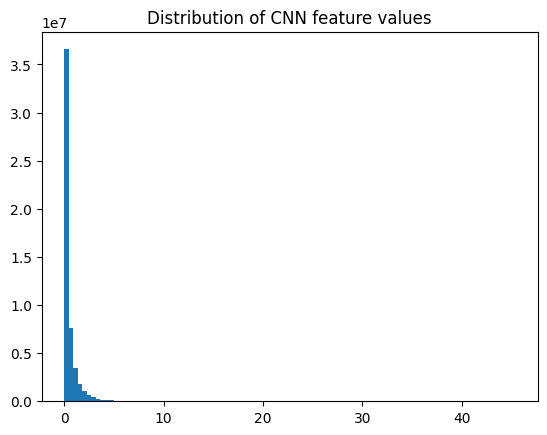

In [18]:
plt.hist(X.flatten(), bins=100)
plt.title("Distribution of CNN feature values")
plt.show()
# normal distribution centered around 0

## 5. Next Steps

- Keep `01_extract_features.ipynb` and `02_kmeans_clustering.ipynb` in the same folder.
- After running this notebook, you will have `X_features.npy` in that folder.
- You can then open and run `02_kmeans_clustering.ipynb` without modifying the loading line:

```python
X = np.load('X_features.npy')
```
